In [3]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 48.6 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.4 MB/s eta 0:00:00


In [4]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=d0ca115f14e6a1345e8220e9c17bf8fdf5fc0eb1bbb168ffd5619441fce29a4a
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, 
                          DataCollatorWithPadding, 
                          Trainer, 
                          TrainingArguments, 
                          AutoModelForSequenceClassification, 
                          EarlyStoppingCallback)
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             accuracy_score, 
                             precision_recall_fscore_support)
from langdetect import detect
from wordcloud import WordCloud
from collections import Counter
import re

plt.style.use('ggplot')


In [7]:
# Load and process dataset
def load_data(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    comment = None
    for line in lines:
        line = line.strip()
        if line.startswith("#"):
            continue
        elif line.startswith("{"):
            labels = re.findall(r"\{(.*?)\}", line)
            for label in labels:
                if "," in label:
                    aspect, sentiment = label.split(", ")
                    data.append({
                        "comment": comment.strip(),
                        "aspect": aspect.strip(),
                        "sentiment": sentiment.strip(),
                    })
        elif line:
            comment = line

    return pd.DataFrame(data)

In [8]:
# Text cleaning
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9À-ỹ\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [9]:
# Dataset class for PyTorch
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [1]:
# File path (replace with your actual file path)
file_path = "data/Train.txt"


In [11]:
# Load and preprocess data
df = load_data(file_path)
# df["comment"] = df["comment"].apply(clean_text).apply(handle_negation).apply(remove_stopwords)
df["comment"] = df["comment"].apply(clean_text)
# Encode labels
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["comment"], df["sentiment"], test_size=0.2, random_state=42, stratify=df["sentiment"]
)


In [12]:
# Load PhoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

# Tokenize data
def tokenize_data(comments):
    return tokenizer(
        comments.tolist(),
        max_length=256,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

train_encodings = tokenize_data(X_train)
test_encodings = tokenize_data(X_test)

# Create datasets
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

# Data collator (tự động padding theo batch)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [13]:
training_args = TrainingArguments(
    output_dir="./results",  # Thư mục lưu kết quả
    num_train_epochs=5,  # Tăng số epoch để học sâu hơn
    per_device_train_batch_size=16,  # Batch size lớn hơn nếu GPU cho phép
    per_device_eval_batch_size=16,
    warmup_steps=1000,  # Tăng warm-up steps để khởi động tốt hơn
    weight_decay=0.01,  # Weight decay để regularization
    logging_dir="./logs",  # Thư mục ghi log
    logging_steps=200,  # Ghi log sau mỗi 200 bước
    evaluation_strategy="epoch",  # Đánh giá sau mỗi epoch
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    load_best_model_at_end=True,  # Tải mô hình tốt nhất sau khi train
    metric_for_best_model="f1",  # Chọn F1 làm tiêu chí tốt nhất
    fp16=True,  # Mixed precision để tăng tốc huấn luyện
    report_to="none",  # Không dùng WandB
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [15]:
# 3. Sử dụng mô hình PhoBERT và tăng dropout
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base-v2",
    num_labels=3,
    hidden_dropout_prob=0.3,  # Tăng dropout để giảm overfitting
    attention_probs_dropout_prob=0.3
)

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# 4. Sử dụng Early Stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Dừng sớm nếu không cải thiện sau 2 epoch
)


In [17]:
# Train model
trainer.train()

<ipython-input-9-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.995000,0.929673,0.599894,0.520848,0.476738,0.599894
2,0.789900,0.670191,0.736258,0.718051,0.732360,0.736258
3,0.673100,0.592339,0.743658,0.744031,0.746151,0.743658
4,0.598100,0.559715,0.767970,0.767413,0.767787,0.767970
5,0.525100,0.559111,0.762685,0.757354,0.756695,0.762685


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-9-016044f5030e>:11: UserWarning: To copy construct from

TrainOutput(global_step=2365, training_loss=0.7314158304549171, metrics={'train_runtime': 459.0174, 'train_samples_per_second': 82.415, 'train_steps_per_second': 5.152, 'total_flos': 1944058709502000.0, 'train_loss': 0.7314158304549171, 'epoch': 5.0})

In [18]:
# Evaluate model
results = trainer.evaluate()
print("Evaluation Results:", results)

<ipython-input-9-016044f5030e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Evaluation Results: {'eval_loss': 0.559715211391449, 'eval_accuracy': 0.7679704016913319, 'eval_f1': 0.7674127168071918, 'eval_precision': 0.7677873006120352, 'eval_recall': 0.7679704016913319, 'eval_runtime': 5.175, 'eval_samples_per_second': 365.604, 'eval_steps_per_second': 22.995, 'epoch': 5.0}


In [19]:
# Predict single comment
def predict_sentiment(comment):
    model.eval()
    inputs = tokenizer(
        comment,
        return_tensors="pt",
        max_length=256,
        padding="max_length",
        truncation=True
    )
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
        return sentiment_map[prediction]


# Test prediction
comments = [
    # Positive comments
    "Món ăn cực kỳ ngon, phục vụ nhiệt tình, giá cả hợp lý!",
    "Không gian quán ấm cúng, đồ ăn chất lượng, chắc chắn sẽ quay lại!",
    "Giá cả phải chăng mà chất lượng thì khỏi bàn, rất đáng để thử!",
    # Neutral comments
    "Món ăn ổn, giá cả phù hợp với chất lượng.",
    "Không gian quán hơi nhỏ nhưng sạch sẽ và thoáng mát.",
    "Chất lượng món ăn và giá cả tương xứng, không có gì để phàn nàn.",
    # Negative comments
    "Giá cao nhưng chất lượng món ăn không tương xứng, khá thất vọng.",
    "Phục vụ chậm, món ăn không nóng, trải nghiệm không tốt.",
    "Thức ăn quá mặn, giá lại cao, sẽ không quay lại lần sau."
]

# Predict sentiment for each comment
for i, comment in enumerate(comments):
    sentiment = predict_sentiment(comment)
    print(f"Comment {i+1}: {comment}")
    print(f"Predicted Sentiment: {sentiment}")
    print("-" * 50)


Comment 1: Món ăn cực kỳ ngon, phục vụ nhiệt tình, giá cả hợp lý!
Predicted Sentiment: positive
--------------------------------------------------
Comment 2: Không gian quán ấm cúng, đồ ăn chất lượng, chắc chắn sẽ quay lại!
Predicted Sentiment: positive
--------------------------------------------------
Comment 3: Giá cả phải chăng mà chất lượng thì khỏi bàn, rất đáng để thử!
Predicted Sentiment: positive
--------------------------------------------------
Comment 4: Món ăn ổn, giá cả phù hợp với chất lượng.
Predicted Sentiment: positive
--------------------------------------------------
Comment 5: Không gian quán hơi nhỏ nhưng sạch sẽ và thoáng mát.
Predicted Sentiment: positive
--------------------------------------------------
Comment 6: Chất lượng món ăn và giá cả tương xứng, không có gì để phàn nàn.
Predicted Sentiment: neutral
--------------------------------------------------
Comment 7: Giá cao nhưng chất lượng món ăn không tương xứng, khá thất vọng.
Predicted Sentiment: negative

In [ ]:
# Đọc dữ liệu từ file comments.csv
comments_file_path = "data/comments.csv"
comments_df = pd.read_csv(comments_file_path)

In [21]:
# Hàm dự đoán cảm xúc
def predict_sentiment(comment):
    model.eval()
    inputs = tokenizer(
        comment,
        return_tensors="pt",
        max_length=256,
        padding="max_length",
        truncation=True
    )
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        sentiment_map = {0: "negative", 1: "neutral", 2: "positive"}
        return sentiment_map[prediction]

# Áp dụng mô hình dự đoán cảm xúc vào dữ liệu
comments_df["Predicted_Sentiment"] = comments_df["description"].apply(predict_sentiment)


In [22]:
comments_df.head()

,_id,userId,restaurantId,rate,time,title,description,Predicted_Sentiment
0,678136022e6c6fe7a4d962d4,67812080426d11b58b7f0500,67812ec1514dba6089ed92ac,7.8,14/9/2024 19:24,What is the truth?,I’ve been eating from this restaurant for more...,positive
1,678136022e6c6fe7a4d962d5,67812080426d11b58b7f04cb,67812ec1514dba6089ed92ac,3.0,28/6/2024 15:07,Cua quá dỡ,"Mua hộp cơm xào cua ăn mà thấy cua ko dc tươi,...",negative
2,678136022e6c6fe7a4d962d6,67812080426d11b58b7f0524,67812ec1514dba6089ed92ac,1.0,14/1/2024 18:41,"đồ ăn rất tệ , không biêt có đúng tiệm không? ...",Dồ ăn quá tệ,negative
3,678136022e6c6fe7a4d962d7,67812080426d11b58b7f0412,67812ec1514dba6089ed92ac,6.0,9/10/2023 18:54,Miến Cua 94 - Chính Gốc,Cơm xào cua nhiều cua ngon đáng tiền,positive
4,678136022e6c6fe7a4d962d8,67812080426d11b58b7f060a,67812ec1514dba6089ed92ac,9.4,8/8/2022 22:15,Miến Cua 94 - Chính Gốc,"Nhìn quán khá hấp dẫn, có dịp mình sẽ ghé lại ...",positive


In [23]:
# Chuyển rate về số
comments_df["rate"] = pd.to_numeric(comments_df["rate"], errors="coerce")

In [25]:
# Gán điểm số cho cảm xúc
sentiment_scores = {"negative": 1, "neutral": 2, "positive": 3}
comments_df["Sentiment_Score"] = comments_df["Predicted_Sentiment"].map(sentiment_scores)

In [26]:
# Chuẩn hóa Sentiment_Score về thang điểm 1-10
comments_df["Sentiment_Score"] = ((comments_df["Sentiment_Score"] - 1) / 2) * 9 + 1

# Tính điểm trung bình giữa rate và cảm xúc
comments_df["Avg_Combined_Score"] = (comments_df["rate"] + comments_df["Sentiment_Score"]) / 2

In [27]:
# Nhóm theo restaurantId
restaurant_analysis = comments_df.groupby("restaurantId").agg(
    Avg_Rate=("rate", "mean"),
    Avg_Sentiment_Score=("Sentiment_Score", "mean"),
    Avg_Combined_Score=("Avg_Combined_Score", "mean"),
    Positive_Count=("Predicted_Sentiment", lambda x: (x == "positive").sum()),
    Negative_Count=("Predicted_Sentiment", lambda x: (x == "negative").sum()),
    Neutral_Count=("Predicted_Sentiment", lambda x: (x == "neutral").sum()),
    Total_Reviews=("Predicted_Sentiment", "count")
).reset_index()


In [28]:
restaurant_analysis

,restaurantId,Avg_Rate,Avg_Sentiment_Score,Avg_Combined_Score,Positive_Count,Negative_Count,Neutral_Count,Total_Reviews
0,67812ec1514dba6089ed92ac,5.260000,4.600000,4.930000,9,15,6,30
1,67812ec1514dba6089ed92ad,6.600000,5.500000,6.050000,1,1,0,2
2,67812ec1514dba6089ed92ae,8.800000,10.000000,9.400000,1,0,0,1
3,67812ec1514dba6089ed92af,5.833333,2.500000,4.166667,0,4,2,6
4,67812ec1514dba6089ed92b0,6.771429,6.142857,6.457143,7,5,2,14
...,...,...,...,...,...,...,...,...
446,67812ec1514dba6089ed9491,7.600000,7.750000,7.675000,1,0,1,2
447,67812ec1514dba6089ed9493,7.000000,5.500000,6.250000,0,0,1,1
448,67812ec1514dba6089ed9496,5.000000,1.000000,3.000000,0,1,0,1
449,67812ec1514dba6089ed9497,7.000000,7.000000,7.000000,1,0,2,3


In [29]:
# Tính tỷ lệ cảm xúc
restaurant_analysis["Positive_Rate"] = restaurant_analysis["Positive_Count"] / restaurant_analysis["Total_Reviews"]
restaurant_analysis["Negative_Rate"] = restaurant_analysis["Negative_Count"] / restaurant_analysis["Total_Reviews"]
restaurant_analysis["Neutral_Rate"] = restaurant_analysis["Neutral_Count"] / restaurant_analysis["Total_Reviews"]


In [31]:
restaurant_analysis["Final_Score"] = (
    restaurant_analysis["Avg_Combined_Score"] +
    (restaurant_analysis["Positive_Rate"] * 2) +
    (restaurant_analysis["Neutral_Rate"] * 1) -
    (restaurant_analysis["Negative_Rate"] * 2)
)


In [32]:
# Chuẩn hóa Final_Score về thang điểm 1-10
min_score = restaurant_analysis["Final_Score"].min()
max_score = restaurant_analysis["Final_Score"].max()
restaurant_analysis["Final_Score_Normalized"] = 1 + 9 * (restaurant_analysis["Final_Score"] - min_score) / (max_score - min_score)


In [33]:
# Xác định loại nhà hàng dựa trên Final_Score
def classify_restaurant(score):
    if score >= 7:
        return "Positive"
    elif score >= 4:
        return "Neutral"
    else:
        return "Negative"

restaurant_analysis["Category"] = restaurant_analysis["Final_Score_Normalized"].apply(classify_restaurant)

# Sắp xếp nhà hàng theo điểm xếp hạng
restaurant_ranking = restaurant_analysis.sort_values(by="Final_Score_Normalized", ascending=False)


In [34]:
restaurant_analysis

,restaurantId,Avg_Rate,Avg_Sentiment_Score,Avg_Combined_Score,Positive_Count,Negative_Count,Neutral_Count,Total_Reviews,Positive_Rate,Negative_Rate,Neutral_Rate,Final_Score,Final_Score_Normalized,Category
0,67812ec1514dba6089ed92ac,5.260000,4.600000,4.930000,9,15,6,30,0.300000,0.500000,0.200000,4.730000,4.966923,Neutral
1,67812ec1514dba6089ed92ad,6.600000,5.500000,6.050000,1,1,0,2,0.500000,0.500000,0.000000,6.050000,5.880769,Neutral
2,67812ec1514dba6089ed92ae,8.800000,10.000000,9.400000,1,0,0,1,1.000000,0.000000,0.000000,11.400000,9.584615,Positive
3,67812ec1514dba6089ed92af,5.833333,2.500000,4.166667,0,4,2,6,0.000000,0.666667,0.333333,3.166667,3.884615,Negative
4,67812ec1514dba6089ed92b0,6.771429,6.142857,6.457143,7,5,2,14,0.500000,0.357143,0.142857,6.885714,6.459341,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,67812ec1514dba6089ed9491,7.600000,7.750000,7.675000,1,0,1,2,0.500000,0.000000,0.500000,9.175000,8.044231,Positive
447,67812ec1514dba6089ed9493,7.000000,5.500000,6.250000,0,0,1,1,0.000000,0.000000,1.000000,7.250000,6.711538,Neutral
448,67812ec1514dba6089ed9496,5.000000,1.000000,3.000000,0,1,0,1,0.000000,1.000000,0.000000,1.000000,2.384615,Negative
449,67812ec1514dba6089ed9497,7.000000,7.000000,7.000000,1,0,2,3,0.333333,0.000000,0.666667,8.333333,7.461538,Positive


In [35]:
# Sắp xếp nhà hàng theo điểm xếp hạng
restaurant_ranking = restaurant_analysis.sort_values(by="Final_Score_Normalized", ascending=False)


count    451.000000
mean       7.221440
std        2.036080
min        1.000000
25%        6.037692
50%        7.500405
75%        8.818132
max       10.000000
Name: Final_Score_Normalized, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


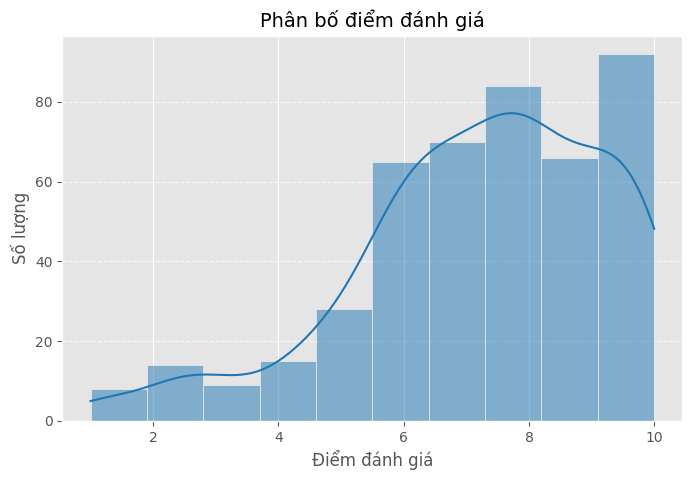

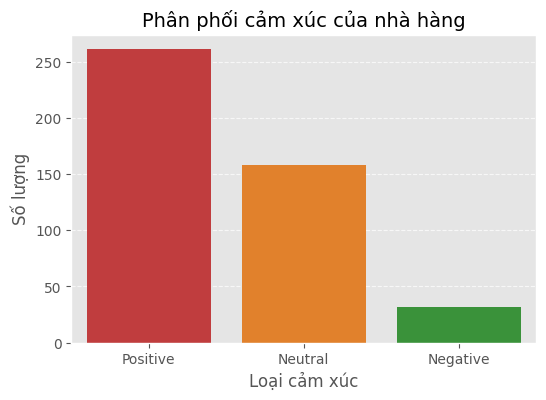

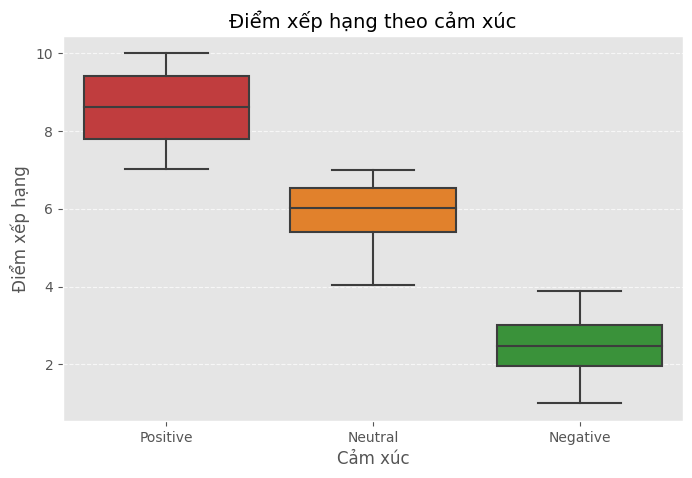

In [36]:
# Hiển thị thống kê mô tả của điểm đánh giá
print(restaurant_ranking['Final_Score_Normalized'].describe())

# Vẽ biểu đồ phân bố điểm đánh giá
plt.figure(figsize=(8, 5))
sns.histplot(restaurant_ranking['Final_Score_Normalized'], bins=10, kde=True, color='#1f77b4')  # Màu xanh đậm
plt.title('Phân bố điểm đánh giá', fontsize=14)
plt.xlabel('Điểm đánh giá', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Vẽ biểu đồ phân phối cảm xúc với màu sắc nổi bật
plt.figure(figsize=(6, 4))
sns.countplot(data=restaurant_ranking, x='Category', palette=['#d62728', '#ff7f0e', '#2ca02c'])  # Đỏ, cam, xanh lá
plt.title('Phân phối cảm xúc của nhà hàng', fontsize=14)
plt.xlabel('Loại cảm xúc', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# So sánh điểm xếp hạng giữa các nhóm cảm xúc
plt.figure(figsize=(8, 5))
sns.boxplot(data=restaurant_ranking, x='Category', y='Final_Score_Normalized', palette=['#d62728', '#ff7f0e', '#2ca02c'])
plt.title('Điểm xếp hạng theo cảm xúc', fontsize=14)
plt.xlabel('Cảm xúc', fontsize=12)
plt.ylabel('Điểm xếp hạng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:

# Sắp xếp nhà hàng theo điểm xếp hạng
def categorize_restaurant(score):
    if score >= 7:
        return "Positive"
    elif score >= 4:
        return "Neutral"
    else:
        return "Negative"

def sort_restaurants(restaurant_ranking, restaurants_path, output_path):
    # Đọc dữ liệu từ file
    ranking_df = restaurant_ranking
    restaurants_df = pd.read_csv(restaurants_path)
    
    # Đổi tên cột restaurantId trong ranking_df để khớp với _id trong restaurants_df
    ranking_df.rename(columns={"restaurantId": "_id"}, inplace=True)
    
    # Gộp dữ liệu theo _id, giữ lại tất cả nhà hàng
    merged_df = restaurants_df.merge(ranking_df, on="_id", how="left")
    
    # Xử lý Final_Score_Normalized
    merged_df["Final_Score_Normalized"] = merged_df["Final_Score_Normalized"].fillna(merged_df["avgRating"])
    
    # Tính cột trung bình giữa avgRating và Final_Score_Normalized
    merged_df["average_score"] = merged_df.apply(
        lambda row: row["avgRating"] if pd.isna(row["Final_Score_Normalized"]) else 
                    (row["avgRating"] + row["Final_Score_Normalized"]) / 2, axis=1
    )
    
    # Phân loại nhà hàng dựa trên average_score
    merged_df["classification"] = merged_df["average_score"].apply(categorize_restaurant)
    
    # Sắp xếp nhà hàng theo average_score giảm dần
    merged_df = merged_df.sort_values(by="average_score", ascending=False)
    
    # Chọn các cột cần thiết
    selected_columns = [
        "_id", "name", "cuisines", "address", "locationRate", "qualityRate", "serviceRate", 
        "priceRate", "spaceRate", "avgRating", "priceRange", "timeOpen", 
        "Final_Score_Normalized", "average_score", "classification",
    ]
    sorted_df = merged_df[selected_columns]
    
    # Lưu vào file mới
    sorted_df.to_csv(output_path, index=False)
    print(f"Dữ liệu đã được lưu vào: {output_path}")

# Đường dẫn tệp

restaurants_file = "data/restaurants.csv"
output_file = "sorted_restaurants.csv"

# Gọi hàm
sort_restaurants(restaurant_ranking, restaurants_file, output_file)


Dữ liệu đã được lưu vào: sorted_restaurants.csv
